In [187]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
import time
import numpy as np
import scipy as sp
from scipy import stats
import scipy.optimize as optimize
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
from collections import Counter
import seaborn as sns; sns.set()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

import itertools

from pyecharts.charts import Map, Geo
from pyecharts.faker import Faker
from pyecharts import options as opts
from pyecharts.globals import ChartType, SymbolType
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from __future__ import unicode_literals
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.commons.utils import JsCode

import import_ipynb
from utils_common import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from adjustText import adjust_text

In [26]:
# Compress warnings: everyone will be tired of warnings (pretend that they do not exist...)
import warnings
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.")

In [27]:
_Data_PATH_XX_ = './data/parameters_xx/'
_Data_PATH_MXX_ = './data/parameters_mxx/' # m stands for migration

_Figure_PATH_ = './figures/'

_City_PATH_ = './data/data_DXY_city_all.csv'
_Province_PATH_ = './data/data_DXY_province_all.csv'
_Province_Domestic_PATH_ = './data/data_DXY_province_all_domestic.csv'
_City_MPATH_ = './data/data_bdqx_if_city.csv'
_Province_MPATH_ = './data/data_bdqx_if_province.csv'

In [28]:
# color palettes
armyrose = ['#798234', '#a3ad62', '#d0d3a2', '#fdfbe4', '#f0c6c3', '#df91a3', '#d46780']
fall = ['#3d5941', '#778868', '#b5b991', '#f6edbd', '#edbb8a', '#de8a5a', '#ca562c']
geyser = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a', '#ca562c']
temps = ['#009392', '#39b185', '#9ccb86', '#e9e29c', '#eeb479', '#e88471', '#cf597e']
tealrose = ['#009392', '#72aaa1', '#b1c7b3', '#f1eac8', '#e5b9ad', '#d98994', '#d0587e']
tropic = ['#009B9E', '#42B7B9', '#A7D3D4', '#F1F1F1', '#E4C1D9', '#D691C1', '#C75DAB']
earth = ['#A16928', '#bd925a', '#d6bd8d', '#edeac2', '#b5c8b8', '#79a7ac', '#2887a1']

In [29]:
# load internal flow index
def load_if_raw():
    raw_city = pd.read_csv(_City_MPATH_)
    raw_province = pd.read_csv(_Province_MPATH_) 
    raw_city['update_date'] = pd.to_datetime(raw_city['update_date'])
    raw_city['update_date'] = raw_city['update_date'].dt.date 
    raw_province['update_date'] = pd.to_datetime(raw_province['update_date'])
    raw_province['update_date'] = raw_province['update_date'].dt.date
    return raw_city, raw_province

In [30]:
# load parameters and estimation for every province # WITH MIGRATION
def load_ind_simulation_raw_mxx_recursive(repetition):
    _Data_PATH_MXXR_ = './data/parameters_mxx_recursive_' + str(repetition) + '/'
    df_parameters_list = []
    df_estimation_list = []
    for name in names_province:
        df_parameters_single = pd.read_csv(_Data_PATH_MXXR_ + name + '_mparameters.csv')
        df_estimation_single = pd.read_csv(_Data_PATH_MXXR_ + name + '_mestimation.csv')
        df_parameters_list.append(df_parameters_single)
        df_estimation_list.append(df_estimation_single)
    return df_parameters_list, df_estimation_list
# 
def load_ind_simulation_raw_mxxr(repetition):
    _Data_PATH_MXXR_ = './data/parameters_mxxr_' + str(repetition) + '/'
    df_parameters_list = []
    df_estimation_list = []
    for name in names_province:
        df_parameters_single = pd.read_csv(_Data_PATH_MXXR_ + name + '_mparameters.csv')
        df_estimation_single = pd.read_csv(_Data_PATH_MXXR_ + name + '_mestimation.csv')
        df_parameters_list.append(df_parameters_single)
        df_estimation_list.append(df_estimation_single)
    return df_parameters_list, df_estimation_list

In [31]:
# Calcuate the standard errors of parameters (from script: utils_parameters)
# reference: Dueling biological and social contagions, Feng Fu
# a linear approximation through estimation of the Jacobian matrix: 
# cov = sigma^2(F'F)^(-1)
# the unbiased estimation of sigma^2 obtained from the residuals of the parameter estimation:
# sigma = error/sqrt(number of observations - number of free parameters)

def SDE_xx(df_parameters_list, porvince_index, T = 21, TT = 6, TI = 3, ti = 7, figure = False):
    
    df_parameters = df_parameters_list[porvince_index].copy() # the parameters
    df_estimation = df_estimation_list[porvince_index].copy() # the estimation
    
    timespan = df_estimation.shape[0] # national timespan
    timespan_local = timespan - df_estimation['real'].isnull().sum() # provincial timespan
    
    e = np.linalg.norm(df_estimation.tail(timespan_local).residual) # Euclidean Norm of the residual
    k = df_parameters.shape[0] - 2 # number of free parameters (exclude N and S)
    sigma_e = e/np.sqrt(timespan_local - k) # sigma
    
    ps_old = dict(zip(df_parameters.parameter, df_parameters.value))
    para_list = df_parameters.parameter.tolist() 
    para_list.remove('N')
    para_list.remove('S_0')
    
    list_front = np.repeat(range(int(np.ceil(T/TI))), TI).tolist()
    list_end = np.repeat(range(int(np.ceil((timespan - T)/ti))), ti).tolist()
    list_end = [item + max(list_front) + 1 for item in list_end]
    index_list = list_front + list_end
    index_list = index_list[:timespan] # index list for beta
    list_front_gs = [0]*TT + [1]*TT
    list_end_gs = [2]*(timespan - TT - TT)
    index_list_gs = list_front_gs + list_end_gs # index list for gamma and sigma
    
    ts = range(0, timespan)
    nbeta = int(T/TI + np.ceil((timespan - T)/ti)) # number of beta's
    
    # Least-square fitting
    def SEIR_equations(states, t, ps):
        """Receptor synthesis-internalization model."""
        # integrate.ode may generate t values outside the data range
        beta_index = index_list[min(round(t), timespan - 1)]
        gs_index = index_list_gs[min(round(t), timespan - 1)]
        beta = ps['beta_' + str(beta_index)]
        gamma = ps['gamma_' + str(gs_index)]
        sigma = ps['sigma_' + str(gs_index)]
        N = ps['N']
        S, E, I, R = states
        return [-beta*S*I/N, beta*S*I/N - sigma*E, sigma*E - gamma*I, gamma*I]
    
    def SEIR(states_0, ts, ps):
        """
        Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
        """
        states = odeint(SEIR_equations, states_0, ts, args=(ps,))
        return states
    
    # Calculate the estimation
    def estimation(ps, ts):
        states_0 = ps['N'] - ps['E_0'] - ps['I_0'] - ps['R_0'], ps['E_0'], ps['I_0'], ps['R_0']
        model = SEIR(states_0, ts, ps)
        est = model[:,3]
        return est
    
    J = np.zeros((timespan_local, k)) # Jacobian matrix
    
    for j in range(0, k):
        para = para_list[j]
        para_value_old = ps_old[para]
        if para_value_old >= 1e-10:
            para_value_change = 1e-2*para_value_old # difference = one percent
        else: # in case the value of a parameter is zero
            para_value_change = 1e-12 
        ps_new = dict(zip(df_parameters.parameter, df_parameters.value))
        ps_new[para] = para_value_old + para_value_change
        final = estimation(ps_new, ts)
        J[:,j] = (df_estimation.tail(timespan_local).estimation - final[-timespan_local:])/para_value_change
        
        palette = plt.get_cmap('magma')
        if figure:
            fig = plt.figure(figsize = (10,5))
            plt.plot(ts, df_estimation.estimation, '-', linewidth = 2, color = palette(0.6))
            plt.plot(ts, final, '--', linewidth = 2, color = palette(0.8))
            plt.title(para)
            plt.xlabel('Date')
            plt.ylabel('Number of people')
        
    H = np.transpose(J).dot(J)
    H_inverse = np.linalg.inv(H)
    df_parameters["sde"] = np.nan
    df_parameters["lower_bound"] = np.nan
    df_parameters["upper_bound"] = np.nan
    
    for j in range(0, k):
        para = para_list[j]
        df_parameters.loc[df_parameters.parameter == para, 'sde'] = sigma_e*np.sqrt(H_inverse[j][j]/ps_old['N'])
    # calculate the lower bound and upper bound of every parameter (99.9% confidence interval)
    # lower bound is non-negative
    # !!! ignore nan !!!
    df_parameters["lower_bound"] = df_parameters.apply(lambda row: np.nanmax([row.value - row.sde*stats.t.ppf(1-0.0005, timespan_local - k), 0]), axis = 1)
    df_parameters["upper_bound"] = df_parameters.apply(lambda row: row.value + row.sde*stats.t.ppf(1-0.0005, timespan_local - k), axis = 1)
    ###### the value of beta cannot be less than 0.01
    ###### the value of beta cannot exceed 1
    for j in range(max(index_list) + 1):
        df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'lower_bound'] = np.nanmax([df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'lower_bound'].tolist()[0], 0.01])
        df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'upper_bound'] = np.nanmin([df_parameters.loc[df_parameters.parameter == 'beta_' + str(int(j)), 'upper_bound'].tolist()[0], 1])
    ###### the value of gamma and sigma cannot be less than 0.05
    ###### the value of gamma and sigma cannot exceed 0.5
    for j in range(max(index_list_gs) + 1):
        df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'lower_bound'] = np.nanmax([df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'lower_bound'].tolist()[0], 0.05])
        df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'lower_bound'] = np.nanmax([df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'lower_bound'].tolist()[0], 0.05])
        
        df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'upper_bound'] = np.nanmin([df_parameters.loc[df_parameters.parameter == 'gamma_' + str(int(j)), 'upper_bound'].tolist()[0], 0.5])
        df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'upper_bound'] = np.nanmin([df_parameters.loc[df_parameters.parameter == 'sigma_' + str(int(j)), 'upper_bound'].tolist()[0], 0.5])
    return df_parameters

In [32]:
# plot real data, estimation from SEIR model without migration, estimation from SEIR model with migration
def figure_conf_est_all(df, names_province, update_date_tr, fsize = (7, 2), ncol = 3, ms = 3, fs = 12, 
                        title = None, country = 'China', tag = 'without', repetition = 10):
    
    sns.set_style("ticks")
    palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062'] # 0, 1, 3
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    
    m = len(names_province)
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    df = df[df.update_date <= update_date_tr]
    df_rank = df[df['update_date'] == max(df['update_date'])].copy()
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    date_initial = min(df.update_date)
    plot_df_list = []
    
    for i, province in enumerate(names_province):
        
        ix = np.unravel_index(i, axes.shape)
        
        if tag == 'without':
            df_estimation = df_estimation_list[i]
        else:
            df_estimation = df_mestimation_list[i]
        
        plot_df = df[df['province_name_en'] == province].copy()
        ##########################################
        if date_initial - min(plot_df.update_date) != datetime.timedelta(0):
            df_initial = pd.DataFrame([[np.nan] * len(plot_df.columns)], columns = plot_df.columns)
            plot_df = df_initial.append(plot_df, ignore_index = True)
            plot_df.iloc[0, plot_df.columns.get_loc('update_date')] = date_initial
            plot_df['update_date'] =  pd.to_datetime(plot_df['update_date'])
            plot_df.set_index('update_date', inplace=True)
            plot_df = plot_df.resample('D').ffill().reset_index()
            plot_df['update_date'] = plot_df['update_date'].dt.date
        ##########################################
        plot_df = plot_df.reset_index()
        plot_df['SEIR'] = df_estimation['estimation']
        if 'mestimation' in df_estimation.columns:
            plot_df['MSEIR'] = df_estimation['mestimation']
        
        plot_df = plot_df.replace({'cum_confirmed': {0: None}})
        
        plot_df_list.append(plot_df)
        
        axes[ix].fill_between(plot_df['update_date'], plot_df['cum_confirmed'],
                                color = palette[2], alpha = 0.6, label = (lambda x: None if x > 0 else 'real data')(i))
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'],
                linewidth = 2, marker = '', ms = ms, color = palette[2], label = str())
    
        axes[ix].plot(plot_df['update_date'], plot_df['SEIR'],
                linewidth = 2, linestyle = '--', marker = '', ms = ms, color = palette[1], label = (lambda x: None if x > 0 else 'estimation w/o migration')(i))
        if 'mestimation' in df_estimation.columns:
            axes[ix].plot(plot_df['update_date'], plot_df['MSEIR'],
                linewidth = 2, marker = '', ms = ms, color = palette[0], label = (lambda x: None if x > 0 else 'estimation w migration')(i)) 
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number (cum)', fontsize = fs - 2)
            axes[ix].get_yaxis().set_label_coords(-0.15, 0.5)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        axes[ix].set_title(province, fontsize = fs)
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
        
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
    if 'mestimation' in df_estimation.columns:
        fig.savefig(_Figure_PATH_ + country + '_conf_mseir_' + str(repetition) + '.png', dpi = 400, bbox_inches='tight')
    else:
        fig.savefig(_Figure_PATH_ + country + '_conf_seir_' + str(repetition) + '.png', dpi = 400, bbox_inches='tight')

In [393]:
# plot the correlation between migration and transmission of the disease
# job: 
#### 1 onset
#### At day ? the nth (recovered) patient appeared for every province (Hubei is not included)
#### 1.1. oneset 
# x-axis: cumulative migration index (from start_date to end_date)
# y-axis: number of infected poeple, date the nth patient appeared
##### 1.2. oneset single
# x-axis: cumulative migration index (from start_date to end_date)
# y-axis: date the nth patient appeared
# point size: number of infected poeple
#### 2 incubation
#### compare the value of E_0 (prior estimation without migration VS posterior estimation with migration)
#### find those provinces got most of the asymptomatic carriers from Hubei province
#### 2.1 diff
#### 2.2 ratio
#### 2.3 value
#### 3 scatter
#### 4 heatmap
#### 5 circle
def correlation(nth, top, start_date, end_date, fs, 
                pieces, vr_upper, job = 'onset', diff = 10, ratio = 80, value = 0):
    # At day ? the nth (recovered) patient appeared for every province (Hubei is not included)
    onset = [(name, df_mestimation_list[i].index[round(df_mestimation_list[i].estimation) >= nth].tolist()[0] + 1) for i, name in enumerate(names_province_cn)]
    onset = dict(sorted(onset, key = lambda tup: tup[1])) # sorting
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_single = data_province_domestic[data_province_domestic.update_date == end_date]
        #data_single = data_province_domestic[data_province_domestic.update_date == datetime.date(int(2020),int(3),int(10))]
        data_single = data_single.sort_values(by = 'cum_confirmed', ascending = False)
        data_single = data_single.reset_index(drop = True)
        # for the scatter plot or the heatmap 
        # the order here is different from the global list names_province (imported from utils.common)
        provinces = data_single.province_name
        provinces = [pyecharts_province_dict[temp] for temp in provinces] # pyecharts has its own naming for provinces
        values = data_single.cum_confirmed
    # get the cumulative migration index from start_date to end_date
    data_m = data_network_P2P[(data_network_P2P.update_date >= start_date) & (data_network_P2P.update_date <= end_date)]
    data_m = data_m.drop(['update_date'], axis = 1)
    data_m = data_m.groupby(['source','target'])['value'].sum().reset_index() # adding up
    data_m_single = data_m[data_m.source == '湖北省'].sort_values(by = 'value') # from Hubei province to other province
    data_m_single_top = data_m_single.tail(top) # only keep the top ones
    # for the migration curves (from Hubei to other provinces)
    sources = data_m_single_top.source.tolist()
    targets = data_m_single_top.target.tolist()
    
    # compare the value of E_0 (prior estimation without migration VS posterior estimation with migration)
    # find those provinces got most of the asymptomatic carriers from Hubei province
    if 'diff' in job:
        # prior - posterior > ?
        diff_E_0 = [round(df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0] - 
                         df[df['parameter'] == 'E_0']['value'].tolist()[0]) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in diff_E_0 if item <= - diff]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if diff_E_0[i] <= - diff]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'ratio' in job:
        # ratio < ?%
        ratio_E_0 = [round(100*df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0]/
                             df[df['parameter'] == 'E_0']['value'].tolist()[0], 2) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in ratio_E_0 if item <= ratio]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if ratio_E_0[i] <= ratio]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'value' in job:
        E_0 = [round(df_m[df_m['parameter'] == 'E_0']['value'].tolist()[0]) for df_m in df_mparameters_list]
        E_0_sub = [item for item in E_0 if item >= value]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if E_0[i] >= value]
        provinces_sub = [pyecharts_province_dict[temp] for temp in names_province_cn]
    
    if "circle" in job:
        # add more edges
        targets_current = []
        while set(targets_current)!= set(targets):
            targets_diff = [temp for temp in targets if temp not in targets_current]
            targets_current = targets.copy()
            for target in targets_diff:
                data_m_ssingle = data_m[data_m.source == target].sort_values(by = 'value')
                sources += [target]*top
                targets += data_m_ssingle.tail(top).target.tolist()
                
    sources = [pyecharts_province_dict[temp] for temp in sources]
    targets = [pyecharts_province_dict[temp] for temp in targets]
    # add new columns to the dataframe
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_m_single['ranking'] = data_m_single.apply(lambda row: data_single.index[data_single['province_name'] == row.target].tolist()[0] + 1, axis = 1) # by number of confirmed cases
        data_m_single['cum_confirmed'] = data_m_single.apply(lambda row: data_single[data_single['province_name'] == row.target]['cum_confirmed'].tolist()[0], axis = 1) 
    data_m_single['onset_date'] = data_m_single.apply(lambda row: timedelta(days = onset[row.target] - 1) + min(data_province_domestic['update_date']), axis = 1) # date
    data_m_single['onset'] = data_m_single.apply(lambda row: onset[row.target], axis = 1) # number
    data_m_single = data_m_single.reset_index(drop = True)
    data_m_single = add_en_location(data_m_single, tag = 'network')
    # Javascript label for pyecharts map
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    adding = start_date.strftime("%d %B, %Y") + ' - ' + end_date.strftime("%d %B, %Y")
    # two panels
    if job == 'onset':
        sns.set_style("whitegrid")
        
        fig = plt.figure(figsize = (10,8))
        ax1 = fig.add_subplot(211)
        palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
        
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, 8) for x in palette)) 
        colors = colors[:data_m_single.shape[0]]
        ax1.scatter(data_m_single.value, data_m_single.cum_confirmed, s = 120, c = colors, alpha = 0.8, 
                    label = 'number of patients')
        #sns.regplot(data_m_single.value, data_m_single.cum_confirmed, # linear regression with error bar
                 #color = palette[2], scatter_kws={"alpha":0.6,"s":0}, label = None)
        ax1.set_xlabel('')
        ax1.set_ylabel('Number of infected', fontsize = fs - 2)
        ax1.legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        ax2 = fig.add_subplot(212)
        palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, 8) for x in palette)) 
        colors = colors[:data_m_single.shape[0]]
        ax2.scatter(data_m_single.value, data_m_single.onset_date, s = 120, c = colors, alpha = 0.8, 
                    label = 'appearance of the ' + str(nth) + 'th patient')
        #sns.regplot(data_m_single.value, data_m_single.onset, 
                 #color = palette[2], scatter_kws={"alpha":0.6,"s":0}, label = None)
        
        ax2.set_xlabel('Cumulative migration index from Hubei', fontsize = fs - 2)
        ax2.set_ylabel('Date', fontsize = fs - 2)
        ax2.set_ylim(min(data_m_single.onset_date) - timedelta(days = 2), max(data_m_single.onset_date) + timedelta(days = 2))
        ax2.yaxis.set_major_locator(mdates.AutoDateLocator())
        ax2.yaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax2.legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        ax1.get_yaxis().set_label_coords(-0.075, 0.5)
        ax2.get_yaxis().set_label_coords(-0.075, 0.5)
        fig.suptitle('Correlation: migration and infection', fontsize = fs, y = 1.01) 
        #fig.savefig(_Figure_PATH_ + 'China_correlation_' + end_date.strftime("%Y-%m-%d") + '.png', dpi = 400, bbox_inches='tight')
        return data_m_single, fig
    
    # only one panel
    elif job == 'onset single':
        
        sns.set_style("whitegrid")
        fig = plt.figure(figsize = (12, 10))
        ax = fig.add_subplot(111)
        palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
        colors = list(itertools.chain.from_iterable(itertools.repeat(x, 8) for x in palette)) 
        colors = colors[:data_m_single.shape[0]]
        # the size of the ith point is linearly related to the number of confirmed cases of the ith province
        ss = [200 + 800*(i-min(data_m_single.cum_confirmed))/(max(data_m_single.cum_confirmed)-min(data_m_single.cum_confirmed)) 
             for i in data_m_single.cum_confirmed.tolist()]
        # generate four intervals
        #r_list = np.linspace(min(data_m_single.cum_confirmed), max(data_m_single.cum_confirmed), 5)
        r_list = data_m_single['cum_confirmed'].quantile([0, 0.25, 0.5, 0.75, 1]).values.tolist()
        for i, r in enumerate(r_list[:-1]):
            indices = [k for k, temp in enumerate(data_m_single.cum_confirmed.tolist()) if (temp >= r) & (temp <= r_list[i+1])]
            s = [temp for k, temp in enumerate(ss) if k in indices]
            ax.scatter(data_m_single.onset_date[indices], data_m_single.value[indices],  s = s, c = palette[i], alpha = 0.8, 
                        label = str(int(r)) + r' $\leq n_{\mathrm{patient}}$ ' + 
                       (lambda x: r'$<$' if x < 3 else r'$\leq$')(i) + str(int(r_list[i+1])))
        for i, name in enumerate(data_m_single.target_en.tolist()):
            if name not in ['Beijing', 'Shanghai']:
                ax.annotate(name, (data_m_single.onset_date[i], data_m_single.value[i]), 
                                   fontsize = fs - 4)
            elif name in ['Beijing', 'Chongqing']:
                ax.annotate(name, (data_m_single.onset_date[i] - timedelta(days = 3), data_m_single.value[i]), 
                                   fontsize = fs - 4)
                days_dict = {'Beijing': 3, 'Chongqing': 3}
                ax.hlines(y = data_m_single.value[i] - 0.02, 
                          xmin = data_m_single.onset_date[i] - timedelta(days = days_dict[name]), 
                          xmax = data_m_single.onset_date[i], 
                          color = 'silver', linewidth = 2, alpha = 0.6, label = None)
            else:
                ax.annotate(name, (data_m_single.onset_date[i] + timedelta(days = 2), data_m_single.value[i]), 
                                   fontsize = fs - 4)
                days_dict = {'Shanghai': 4, 'Tianjin': 3}
                ax.hlines(y = data_m_single.value[i] - 0.02, 
                          xmin = data_m_single.onset_date[i], 
                          xmax = data_m_single.onset_date[i] + timedelta(days = days_dict[name]), 
                          color = 'silver', linewidth = 2, alpha = 0.6, label = None)
        ax.set_xlabel('Appearance of the ' + str(nth) + 'th patient', fontsize = fs - 2)
        ax.set_xlim(min(data_m_single.onset_date) - timedelta(days=2), max(data_m_single.onset_date) + timedelta(days=2))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_yscale('log')
        ax.set_ylim(0.2, 30)
        ax.set_ylabel('Cumulative migration index from Hubei', fontsize = fs - 2)
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 6)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 6)
        
        #ax.set_title(adding, fontsize = fs - 4, y = 1.01) 
        plt.figtext(0.5, 1, adding, ha = "center", va = "top", fontsize = fs - 4)
        fig.suptitle('Correlation: migration and infection', fontsize = fs, y = 1.045)
        ax.legend(loc = 'upper right', fancybox = True, fontsize = fs - 2)
        
        fig.savefig(_Figure_PATH_ + 'China_correlation_' + end_date.strftime("%Y-%m-%d") + '.png', dpi = 400, bbox_inches='tight')
        return data_m_single, fig
    # scatter map
    elif 'scatter' in job:
        c = (
            Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
            .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                "infection",
                [list(z) for z in zip(provinces, values)],
                symbol_size = 15,
                point_size = 5,
            )
            .add(
                "migration",
                list(zip(sources, targets)),
                type_ = ChartType.LINES,
                effect_opts = opts.EffectOpts(
                    is_show = True,
                    symbol = SymbolType.ARROW, 
                    symbol_size = 2,
                    period = 4), # "trailLength": 0 // 生成html后添加，去拖尾 
                linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_='solid'),
                symbol_size = 8,
            )
            .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                        formatter = JsCode(ln), font_size = fs - 8), position = 'top')
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)),
                visualmap_opts = opts.VisualMapOpts(
                    is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                    pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"), # end_date.strftime("%Y-%m-%d")
                                           title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 10),
                                           subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5)))
        )
        if 'circle' in job:
            make_snapshot(snapshot, c.render(),
                  _Figure_PATH_ + "China_map_migration_c_" + str(end_date) + ".png")
        else:
            make_snapshot(snapshot, c.render(),
                  _Figure_PATH_ + "China_map_migration_" + str(end_date) + ".png")
        return data_m_single, c
    else:
    # add E_0 in the heatmap
        if ('diff' in job) | ('ratio' in job) | ('value' in job):
            c = (
                Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    symbol_size = 8,
                    point_size = 5,
                )
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,
                )
                .add(
                    "migration",
                    list(zip(sources, targets)),
                    type_ = ChartType.LINES,
                    color = '#827397',
                    effect_opts = opts.EffectOpts(
                        is_show = (lambda x: False if 'circle' in x else True)(job),
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4),
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_='solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                        range_color = ['#d8b9c3', '#827397', '#4d4c7d', '#363062'],
                                                       textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        else:
            c = (
                Geo(init_opts = opts.InitOpts(width = '900px', height = '600px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    symbol_size = 8,
                    point_size = 5,
                )
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,   
                )
                .add(
                    "migration",
                    list(zip(sources, targets)),
                    color = '#d94e5d', # ["#50a3ba", "#eac763", "#d94e5d"] # "#c23531", "#2f4554",
                    type_ = ChartType.LINES,
                    effect_opts = opts.EffectOpts(
                        is_show = (lambda x: False if 'circle' in x else True)(job),
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4), 
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_ = 'solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                       textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        if 'circle' in job:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + "China_heatmap_migration_incubation_c_" + end_date.strftime("%Y-%m-%d") + ".png")
            else:
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + "China_heatmap_migration_c_" + end_date.strftime("%Y-%m-%d") + ".png")
        else:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + "China_heatmap_migration_incubation_" + end_date.strftime("%Y-%m-%d") + ".png")
            else:
                make_snapshot(snapshot, c.render(),
                              _Figure_PATH_ + "China_heatmap_migration_" + end_date.strftime("%Y-%m-%d") + ".png")
        return data_m_single, c
    

In [394]:
def correlation_html(nth, top, start_date, end_date, fs, 
                pieces, vr_upper, job = 'onset', diff = 10, ratio = 80, value = 0):
    # At day ? the nth (recovered) patient appeared for every province (Hubei is not included)
    onset = [(name, df_mestimation_list[i].index[round(df_mestimation_list[i].estimation) >= nth].tolist()[0] + 1) for i, name in enumerate(names_province_cn)]
    onset = dict(sorted(onset, key = lambda tup: tup[1])) # sorting
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_single = data_province_domestic[data_province_domestic.update_date == end_date]
        #data_single = data_province_domestic[data_province_domestic.update_date == datetime.date(int(2020),int(3),int(10))]
        data_single = data_single.sort_values(by = 'cum_confirmed', ascending = False)
        data_single = data_single.reset_index(drop = True)
        # for the scatter plot or the heatmap 
        # the order here is different from the global list names_province (imported from utils.common)
        provinces = data_single.province_name
        provinces = [pyecharts_province_dict[temp] for temp in provinces] # pyecharts has its own naming for provinces
        values = data_single.cum_confirmed
    # get the cumulative migration index from start_date to end_date
    data_m = data_network_P2P[(data_network_P2P.update_date >= start_date) & (data_network_P2P.update_date <= end_date)]
    data_m = data_m.drop(['update_date'], axis = 1)
    data_m = data_m.groupby(['source','target'])['value'].sum().reset_index() # adding up
    data_m_single = data_m[data_m.source == '湖北省'].sort_values(by = 'value') # from Hubei province to other province
    data_m_single_top = data_m_single.tail(top) # only keep the top ones
    # for the migration curves (from Hubei to other provinces)
    sources = data_m_single_top.source.tolist()
    targets = data_m_single_top.target.tolist()
    
    # compare the value of E_0 (prior estimation without migration VS posterior estimation with migration)
    # find those provinces got most of the asymptomatic carriers from Hubei province
    if 'diff' in job:
        # prior - posterior > ?
        diff_E_0 = [round(df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0] - 
                         df[df['parameter'] == 'E_0']['value'].tolist()[0]) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in diff_E_0 if item <= - diff]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if diff_E_0[i] <= - diff]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'ratio' in job:
        # ratio < ?%
        ratio_E_0 = [round(100*df_mparameters_list[i][df_mparameters_list[i]['parameter'] == 'E_0']['value'].tolist()[0]/
                             df[df['parameter'] == 'E_0']['value'].tolist()[0], 2) for i, df in enumerate(df_parameters_list)]
        E_0_sub = [item for item in ratio_E_0 if item <= ratio]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if ratio_E_0[i] <= ratio]
        provinces_sub = [pyecharts_province_dict[temp] for temp in provinces_sub]
        
    elif 'value' in job:
        E_0 = [round(df_m[df_m['parameter'] == 'E_0']['value'].tolist()[0]) for df_m in df_mparameters_list]
        E_0_sub = [item for item in E_0 if item >= value]
        provinces_sub = [item for i, item in enumerate(names_province_cn) if E_0[i] >= value]
        provinces_sub = [pyecharts_province_dict[temp] for temp in names_province_cn]
    
    if "circle" in job:
        # add more edges
        targets_current = []
        while set(targets_current)!= set(targets):
            targets_diff = [temp for temp in targets if temp not in targets_current]
            targets_current = targets.copy()
            for target in targets_diff:
                data_m_ssingle = data_m[data_m.source == target].sort_values(by = 'value')
                sources += [target]*top
                targets += data_m_ssingle.tail(top).target.tolist()
                
    sources = [pyecharts_province_dict[temp] for temp in sources]
    targets = [pyecharts_province_dict[temp] for temp in targets]
    # add new columns to the dataframe
    if ('diff' not in job) & ('ratio' not in job) & ('value' not in job):
        data_m_single['ranking'] = data_m_single.apply(lambda row: data_single.index[data_single['province_name'] == row.target].tolist()[0] + 1, axis = 1) # by number of confirmed cases
        data_m_single['cum_confirmed'] = data_m_single.apply(lambda row: data_single[data_single['province_name'] == row.target]['cum_confirmed'].tolist()[0], axis = 1) 
    data_m_single['onset_date'] = data_m_single.apply(lambda row: timedelta(days = onset[row.target] - 1) + start_date, axis = 1) # date
    data_m_single['onset'] = data_m_single.apply(lambda row: onset[row.target], axis = 1) # number
    data_m_single = data_m_single.reset_index(drop = True)

    # Javascript label for pyecharts map
    ln = """
    function(params) {
        if(params.name == '湖北')
            return 'Hubei';
        if(params.name == '广东')
            return 'Guangdong';
        if(params.name == '河南')
            return 'Henan';
        if(params.name == '浙江')
            return 'Zhejiang';
        if(params.name == '湖南')
            return 'Hunan';
        return '';
    }
    """
    adding = start_date.strftime("%d %B, %Y") + ' - ' + end_date.strftime("%d %B, %Y")
    # scatter map
    if 'scatter' in job:
        c = (
            Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
            .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
            .add(
                "infection",
                [list(z) for z in zip(provinces, values)],
                symbol_size = 10,
                point_size = 5,
            )
            .add(
                "migration",
                list(zip(sources, targets)),
                type_ = ChartType.LINES,
                effect_opts = opts.EffectOpts(
                    is_show = True,
                    symbol = SymbolType.ARROW, 
                    symbol_size = 2,
                    period = 4), # "trailLength": 0 // 生成html后添加，去拖尾 
                linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.8, type_='solid'),
                symbol_size = 8,
            )
            .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                        formatter = JsCode(ln), font_size = fs - 8), position = 'top')
            .set_global_opts(
                legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                visualmap_opts = opts.VisualMapOpts(
                    is_show = True, split_number = 6, is_piecewise = True, pos_top = 'center',
                    pieces = pieces, textstyle_opts = opts.TextStyleOpts(font_size = fs)),
                title_opts = opts.TitleOpts(title = "China", subtitle = end_date.strftime("%d %B, %Y"), # end_date.strftime("%Y-%m-%d")
                                           title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                           subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
        )
        if 'circle' in job:
            c.render(_Figure_PATH_ + "China_map_migration_c_" + str(end_date) + ".html")
        else:
            c.render(_Figure_PATH_ + "China_map_migration_" + str(end_date) + ".html")

        return data_m_single, c
    else:
    # add E_0 in the heatmap
        if ('diff' in job) | ('ratio' in job) | ('value' in job):
            c = (
                Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    symbol_size = 6,
                    point_size = 5,
                )
                .add(
                    'incubation',
                    [list(z) for z in zip(provinces_sub, E_0_sub)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,
                )
                .add(
                    "migration",
                    list(zip(sources, targets)),
                    type_ = ChartType.LINES,
                    color = '#827397',
                    effect_opts = opts.EffectOpts(
                        is_show = True,
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4),
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.6, type_='solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                  item_width = 20, item_height = 10,),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                        range_color = ['#d8b9c3', '#827397', '#4d4c7d', '#363062'],
                                                        textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                        item_width = 12, item_height = 100,),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        else:
            c = (
                Geo(init_opts = opts.InitOpts(width = '750px', height = '500px', bg_color = "#FFFFFF"),)
                .add_schema(maptype = "china", itemstyle_opts = opts.ItemStyleOpts(color = "white", border_color = "black"),)
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    symbol_size = 6,
                    point_size = 5,
                )
                .add(
                    "infection",
                    [list(z) for z in zip(provinces, values)],
                    color = '#2f4554',
                    type_ = ChartType.HEATMAP,   
                )
                .add(
                    "migration",
                    list(zip(sources, targets)),
                    color = '#d94e5d', # ["#50a3ba", "#eac763", "#d94e5d"] # "#c23531", "#2f4554",
                    type_ = ChartType.LINES,
                    effect_opts = opts.EffectOpts(
                        is_show = True,
                        symbol = SymbolType.ARROW, 
                        symbol_size = 2,
                        period = 4), 
                    linestyle_opts = opts.LineStyleOpts(width = 1.5, curve = 0.2, opacity = 0.6, type_ = 'solid'),
                    symbol_size = 8,
                )
                .set_series_opts(label_opts = opts.LabelOpts(is_show = False,
                            formatter = JsCode(ln), font_size = fs - 8))
                .set_global_opts(
                    legend_opts = opts.LegendOpts(textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                  item_width = 20, item_height = 10,),
                    visualmap_opts = opts.VisualMapOpts(max_ = vr_upper, pos_top = 'center',
                                                       textstyle_opts = opts.TextStyleOpts(font_size = fs),
                                                       item_width = 12, item_height = 100,),
                    title_opts = opts.TitleOpts(title = "China",subtitle = end_date.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = fs + 5),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = fs + 2)))
            )
        if 'circle' in job:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                c.render(_Figure_PATH_ + "China_heatmap_migration_incubation_c_" + str(end_date) + ".html")
            else:
                c.render(_Figure_PATH_ + "China_heatmap_migration_c_" + str(end_date) + ".html")
        else:
            if ('diff' in job) | ('ratio' in job) | ('value' in job):
                c.render(_Figure_PATH_ + "China_heatmap_migration_incubation_" + str(end_date) + ".html")
            else:
                c.render(_Figure_PATH_ + "China_heatmap_migration_" + str(end_date) + ".html")
        return data_m_single, c

In [374]:
# i: the ith province
# name: beta, gamma or sigma
def df_beta_gamma_sigma(df_parameters_list, df_estimation_list, i, name, date_initial, date_tr,
                        T = 21, TT = 6, TI = 3, ti = 7):
    
    df_estimation_single = df_estimation_list[0]
    timespan = df_estimation_single.shape[0]
    list_front = np.repeat(range(int(np.ceil(T/TI))), TI).tolist()
    list_end = np.repeat(range(int(np.ceil((timespan - T)/ti))), ti).tolist()
    list_end = [item + max(list_front) + 1 for item in list_end]
    index_list = list_front + list_end
    index_list = index_list[:timespan] # index list for beta

    list_front_gs = [0]*TT + [1]*TT
    list_end_gs = [2]*(timespan - TT - TT)
    index_list_gs = list_front_gs + list_end_gs # index list for gamma and sigma
    
    df_parameters_single = df_parameters_list[i]
    df_bgs = df_parameters_single[df_parameters_single.parameter.str.contains(name)]
    df_bgs = df_bgs.reset_index(drop = True)
    if name == 'beta':
        df_bgs = df_bgs.loc[index_list]
    else:
        df_bgs = df_bgs.loc[index_list_gs]
    df_bgs = df_bgs.reset_index(drop = True)
    df_bgs['update_date'] = [item for item in daterange(date_initial, date_tr)]
    new_col = ['update_date', 'parameter', 'value', 'sde', 'lower_bound', 'upper_bound']
    df_bgs = df_bgs[new_col]
    return df_bgs
    
# plot the prior (without migration) and posterior (with migration) estimations of beta, gamma or sigma
def figure_parameters(df_parameters_list, df_mparameters_list, df_estimation_list, names_province, update_date_tr,
                      fsize = (5, 3), ncol = 3, ms = 2, fs = 10, title = None, country = 'China',
                      top = False, ndays = 56):
    
    date_initial = min(data_province_domestic['update_date'])

    df = data_province_domestic
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop = True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    sns.set_style("ticks")
    palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    
    if top: # only plot the top 9 most infected provinces 
        df_single = data_province_domestic[data_province_domestic['update_date'] == max(data_province_domestic['update_date'])]
        names_province = df_single.sort_values(by = 'cum_confirmed', ascending = False).head(9).province_name_en.tolist()
        names_province.sort()
        
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    for i, province in enumerate(names_province):
        c = palette[0]
        mc = palette[1]
        df_beta = df_beta_gamma_sigma(df_parameters_list, df_estimation_list, i, 'beta', date_initial, update_date_tr)
        df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
    
        df_bgs = pd.DataFrame(columns = ['update_date', 'beta', 'mbeta'])
        df_bgs['update_date'] = df_beta['update_date']
        df_bgs['beta'] = df_beta['value']
        df_bgs['mbeta'] = df_mbeta['value']

        ix = np.unravel_index(i, axes.shape)
        axes[ix].plot(df_bgs['update_date'], df_bgs['beta'],
                linewidth = 2, marker = 'o', ms = ms, color = c, alpha = 1,
                      label = (lambda x: None if x > 0 else 'prior')(i)) # 
        axes[ix].plot(df_bgs['update_date'], df_bgs['mbeta'],
                linewidth = 2, marker = 'o', ms = ms, color = mc, alpha = 1,
                      label = (lambda x: None if x > 0 else 'posterior')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Value", fontsize = fs - 2)
        if i == 0:    
            axes[ix].legend(loc = 'upper left', ncol = 1, fancybox = True, fontsize = fs - 2)
            
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        axes[ix].set_title(province, fontsize = fs)
        axes[ix].set_xlim(min(df_bgs.update_date), min(df_bgs.update_date) + timedelta(days = ndays - 1)) # only keep the first n days
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
    fig.align_ylabels(axes[:, 0])    
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
        
    fig.savefig(_Figure_PATH_ + country + '_beta.png', dpi = 400, bbox_inches='tight')   

In [375]:
# calculate the cross correlation between infection rate and internal flow index
# a positive lag means the first series lags the second, or the second leads the first: 
# peaks earlier in time, so at a location to the left on the time series plot
def cross_correlation(df_mparameters_list, df_mestimation_list, df_if, update_date_tr, i, ndays = 56, printing = True):
    
    date_initial = min(data_province_domestic['update_date'])
    
    df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
    # only keep the data of the first ndays
    timespan = ndays
    df_mbeta = df_mbeta.head(timespan)

    df_if_single = df_if[df_if['province_name_en'] == names_province[i]].copy()
    df_if_single = df_if_single[df_if_single['update_date'] >= datetime.date(int(2020),int(1),int(1))]
    df_if_single = df_if_single[df_if_single['update_date'] <= date_initial + timedelta(days = timespan-1)]
    df_if_single = df_if_single.reset_index(drop=True)
    
    y_beta = df_mbeta['value'].values
    y_if = df_if_single['n_value'].values
    ccor = []
    lags = np.arange(0, len(y_if) - len(y_beta) + 1) # assume that the lag is positive
    for lag in lags:
        if lag == 0:
            y_if_lag = y_if[-timespan:]
        else:
            y_if_lag = y_if[-timespan-lag: -lag]
        ccov = np.correlate(y_beta - y_beta.mean(), y_if_lag - y_if_lag.mean(), 'full')
        ccor.append(ccov/(timespan * y_beta.std() * y_if_lag.std()))
    if printing:
        print(names_province[i], np.amax(ccor), np.where(ccor == np.amax(ccor))[0][0])
    # find the maximum value of the cross correlations with different lages
    return np.amax(ccor), int(np.where(ccor == np.amax(ccor))[0][0])

In [60]:
# plot the posterior (with migration) estimations of beta and the interflow index
# calculate the lag and the cross correlation for every province
def figure_parameters_if(df_mparameters_list, df_mestimation_list,
                         df_if, names_province, update_date_tr, ndays = 56, 
                         fsize = (5, 3), ncol = 3, ms = 2, fs = 10, title = None, country = 'China', top = False):
    
    date_initial = min(data_province_domestic['update_date'])
    
    df = data_province_domestic
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    sns.set_style("ticks")
    palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    
    if top:
        df_single = data_province_domestic[data_province_domestic['update_date'] == max(data_province_domestic['update_date'])]
        names_province = df_single.sort_values(by='cum_confirmed', ascending = False).head(9).province_name_en.tolist()
        names_province.sort()
        
    m = len(names_province)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (ncol*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    for i, province in enumerate(names_province):
        mc = palette[1]
        df_mbeta = df_beta_gamma_sigma(df_mparameters_list, df_mestimation_list, i, 'beta', date_initial, update_date_tr)
    
        df_bgs = pd.DataFrame(columns = ['update_date', 'mbeta'])
        df_bgs['update_date'] = df_mbeta['update_date']
        df_bgs['mbeta'] = df_mbeta['value']

        ix = np.unravel_index(i, axes.shape)
        
        axes[ix].plot(df_bgs['update_date'], df_bgs['mbeta'],
                linewidth = 2, marker = 'o', ms = ms, color = mc, alpha = 1,
                      label = (lambda x: None if x > 0 else r'$\beta$')(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Value", fontsize = fs - 2)
        if i == 0:    
            axes[ix].legend(loc = 'upper left', ncol = 1, fancybox = True, fontsize = fs - 2)
    
    for i, province in enumerate(names_province):
        ix = np.unravel_index(i, axes.shape)
        ax_twin = axes[ix].twinx()
        ax_twin.grid(False)
        ccor, lag = cross_correlation(df_mparameters_list, df_mestimation_list, df_if, update_date_tr, i, ndays, printing = False)
        df_if_single = df_if[df_if['province_name_en'] == names_province[i]].copy()
        df_if_single = df_if_single[df_if_single['update_date'] >= datetime.date(int(2020),int(1),int(1))]
        df_if_single = df_if_single.reset_index(drop=True)
        df_if_single['update_date'] = df_if_single['update_date'] + timedelta(days = lag)  
        #print(min(df_if_single['update_date']))
        df_if_single = df_if_single[(df_if_single['update_date'] >= min(df_bgs.update_date)) & (df_if_single['update_date'] <= max(df_bgs.update_date))]
        df_if_single = df_if_single.reset_index(drop=True)
        
        c = palette[0]
        ax_twin.plot(df_if_single['update_date'], df_if_single['n_value'],
                linewidth = 2, color = c, alpha = 0.6, label = None)
        ax_twin.fill_between(df_if_single['update_date'], df_if_single['n_value'], min(df_if_single.n_value),
                                color = c, alpha = 0.4, label = 'internal flow')
        hand, label = ax_twin.get_legend_handles_labels()
        if i == 0:
            ax_twin.legend(hand[1:], label[1:], loc = 'upper right', fancybox = True, fontsize = fs - 2)
            
        ax_twin.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax_twin.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if i % ncol == ncol - 1:
            ax_twin.set_ylabel('Ratio', fontsize = fs - 2)
        
        ax_twin.get_yaxis().set_label_coords(1.1, 0.5)
            
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        if i == 0:
            adding = ' (lag = ' + str(lag) + ', ccor = ' + str(round(ccor,4)) + ')'
        else:
            adding = ' (' + str(lag) + ', ' + str(round(ccor, 4)) + ')'
        axes[ix].set_title(province + adding, fontsize = fs)
        axes[ix].set_xlim(min(df_bgs.update_date), min(df_bgs.update_date) + timedelta(days = ndays-1))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
    fig.align_ylabels(axes[:, 0])    
    fig.suptitle(title, fontsize = fs + 2, y = 1.01)
        
    fig.savefig(_Figure_PATH_ + country + '_beta_if.png', dpi = 400, bbox_inches='tight')   

In [39]:
data_city, data_province, data_province_domestic = load_DXY_raw()

In [16]:
date_initial = min(data_province_domestic.update_date)
date_tr = datetime.date(int(2020),int(3),int(10))
data_network_P2P = load_network_raw()
mindex_list_real = matrix_P2P_all(data_network_P2P, date_initial, date_tr)

In [17]:
# Where the imported cases are
data_city_overseas = data_city[data_city.city_name.str.contains('境外')]
sorted(set(data_city_overseas.province_name))

['上海市', '北京市', '山东省', '浙江省', '甘肃省']

In [18]:
df_parameters_list, df_estimation_list = load_ind_simulation_raw_xx()
df_parameters_list = [SDE_xx(df_parameters_list, i) for i in range(0, len(names_province))]

/Users/xingruchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in sqrt


In [56]:
#rep = 40
#df_mparameters_list_o, df_mestimation_list_o = load_ind_simulation_raw_mxx_recursive(rep)
rep = 40
df_mparameters_list_o, df_mestimation_list_o = load_ind_simulation_raw_mxxr(rep)
rep = 50
df_mparameters_list, df_mestimation_list = load_ind_simulation_raw_mxxr(rep)

In [20]:
data_if_city, data_if_province = load_if_raw()

In [22]:
diff = 0
for i, name in enumerate(names_province):
    ccor_o, lag_o = cross_correlation(df_mparameters_list_o, df_mestimation_list_o, data_if_province, date_tr, i, ndays = 56, printing = False)
    ccor, lag = cross_correlation(df_mparameters_list, df_mestimation_list, data_if_province, date_tr, i, ndays = 56, printing = False)
    print(name, ccor - ccor_o, lag_o, lag)
    diff += ccor - ccor_o
diff

Anhui -0.004781194394984922 12 12
Beijing -0.001073792695899689 0 0
Chongqing 0.0003854018803975956 6 6
Fujian -0.009407949132660298 14 14
Gansu 0.0016456121762077336 1 1
Guangdong 0.019795790329364626 9 12
Guangxi -0.023498425000648804 11 12
Guizhou 0.0378787865532223 14 12
Hainan -0.001175169954773403 4 3
Hebei 0.0007747055277828041 9 9
Heilongjiang -0.0005777921108955919 8 8
Henan 0.002349422533077461 7 7
Hubei 0.013403372642169065 14 14
Hunan -0.0010893007330126103 3 3
Inner Mongolia -0.0057851746308432705 2 2
Jiangsu -0.011427074463400078 7 7
Jiangxi 0.012246358527308931 2 1
Jilin -0.0004776793539900126 12 12
Liaoning 4.145333262894901e-05 2 2
Ningxia -0.009245710755373449 9 9
Qinghai -0.014231119777869838 0 0
Shaanxi 0.00841194154998226 0 0
Shandong -0.0014610864547904834 0 0
Shanghai 0.0733413461702127 12 12
Shanxi -0.000710170267845589 11 11
Sichuan 0.006567956110353768 14 14
Tianjin 0.0011789804311654883 14 14
Xinjiang -1.1489304124756572e-05 4 4
Yunnan 0.06395722520866587 4 4

0.14125612376180469

In [23]:
datetime.date(int(2020),int(3),int(10))  - min(data_province_domestic['update_date'])

datetime.timedelta(days=55)

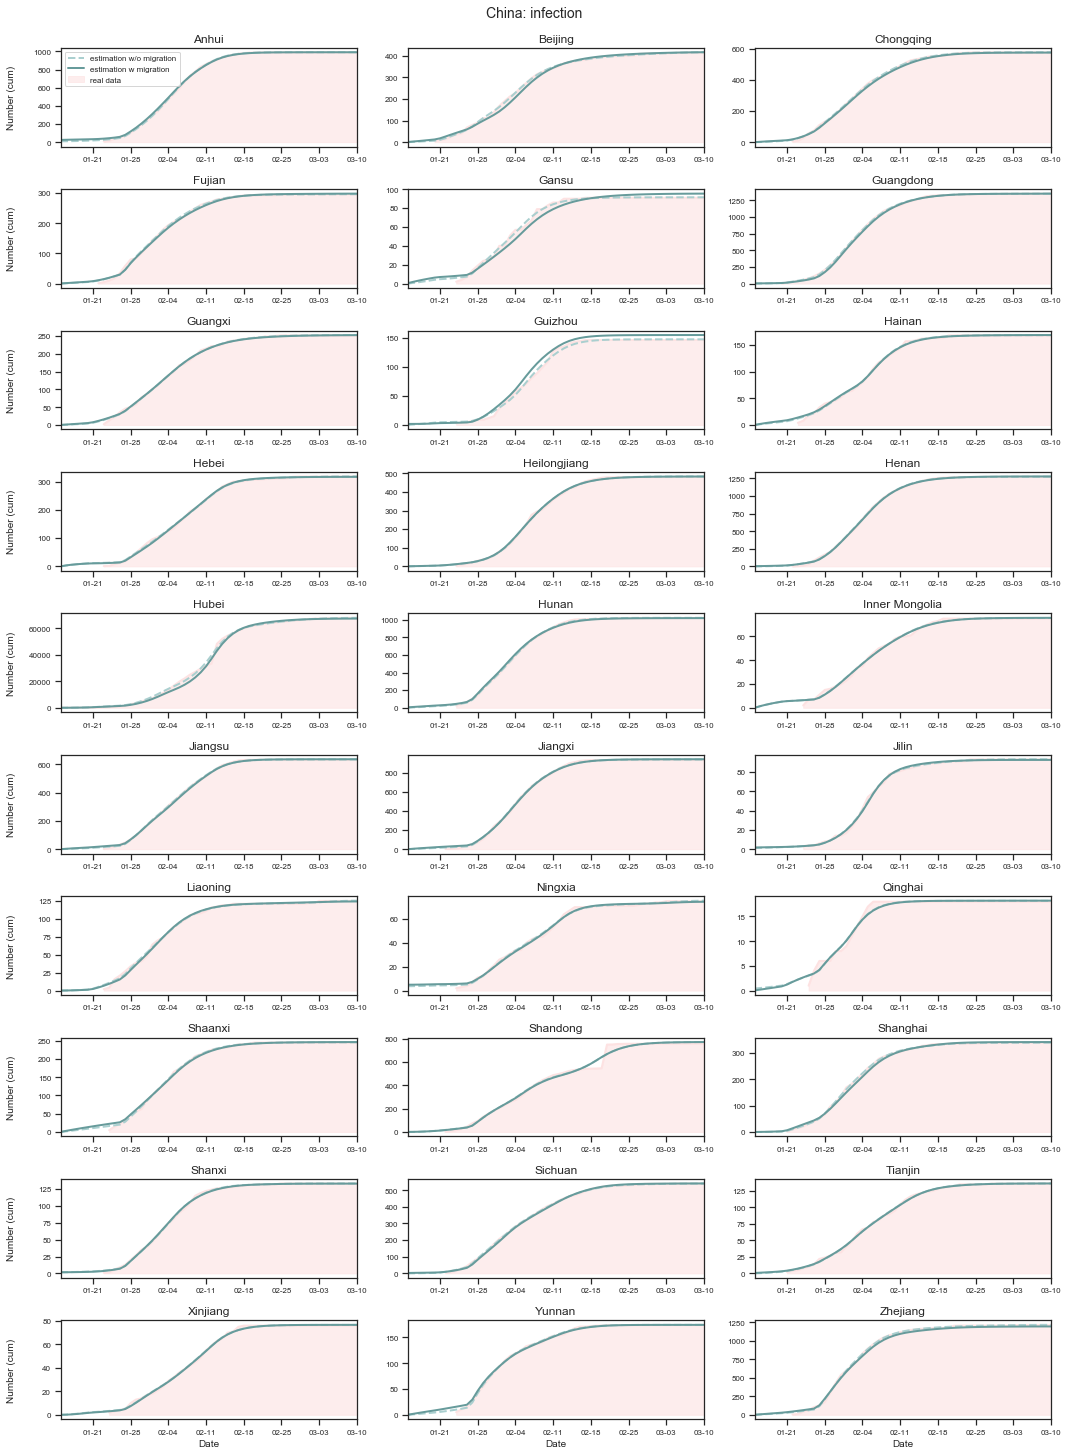

In [40]:
date_initial = min(data_province_domestic.update_date)
date_tr = datetime.date(int(2020),int(3),int(10))
figure_conf_est_all(data_province_domestic, names_province, date_tr, fsize = (5, 2), ncol = 3, ms = 3, fs = 12, 
                    title = 'China: infection', country = 'China', 
                    tag = 'with', repetition = rep)

In [388]:
# Chunyun 2020: from January 10 to February 18
date_initial = datetime.date(int(2020),int(1),int(1))
date_tr = datetime.date(int(2020),int(1),int(27))
pieces_lower = [{'min': 101},  # no max for this
               {'min': 51, 'max': 100},
               {'min': 21, 'max': 50},
               {'min': 11, 'max': 20},
               {'min': 5, 'max': 10},
               {'min': 0, 'max': 5}]
pieces_mid = [{'min': 501},  # no max for this
              {'min': 101, 'max': 500},
              {'min': 51, 'max': 100},
              {'min': 21, 'max': 50},
              {'min': 11, 'max': 20},
              {'min': 0, 'max': 10}]
vr_upper = [50, 100, 500]

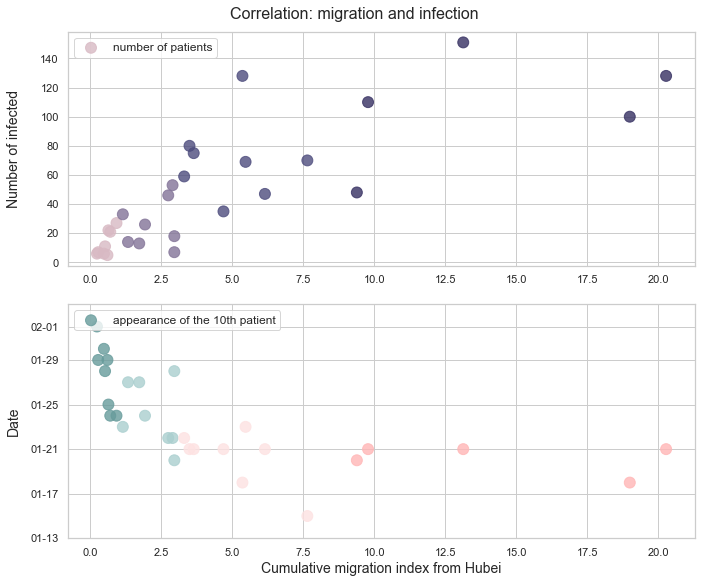

In [389]:
data_m_single, fig = correlation(10, 10, date_initial, date_tr, fs = 16, 
                                 pieces = pieces_mid, vr_upper = vr_upper[1], job = 'onset')

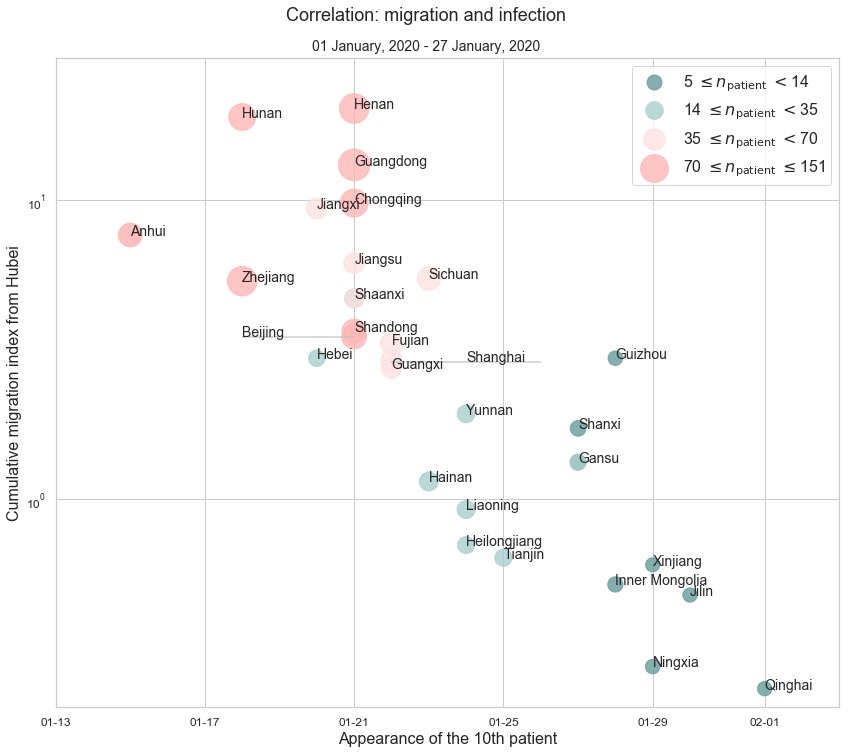

In [390]:
data_m_single, fig = correlation(10, 10, date_initial, date_tr, fs = 18, 
                                 pieces = pieces_mid, vr_upper = vr_upper[1], job = 'onset single')

In [397]:
date_tr = datetime.date(int(2020),int(1),int(27))
data_m_single, c = correlation(15, 10, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap')

In [398]:
data_m_single, c = correlation(15, 3, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap circle')

In [407]:
# with incubation
date_tr = datetime.date(int(2020),int(1),int(14))
data_m_single, c = correlation(15, 10, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap value', value = 0)

In [408]:
# with incubation
data_m_single, c = correlation(15, 3, date_initial, date_tr, 20,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap circle value', value = 0)

In [401]:
date_tr = datetime.date(int(2020),int(1),int(27))
data_m_single, c = correlation_html(15, 10, date_initial, date_tr, 18,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap')
c.render_notebook()

In [402]:
data_m_single, c = correlation_html(15, 3, date_initial, date_tr, 12,
                               pieces = pieces_mid, vr_upper = vr_upper[1], 
                               job = 'heatmap circle')
c.render_notebook()

In [409]:
# with incubation
date_tr = datetime.date(int(2020),int(1),int(14))
data_m_single, c = correlation_html(15, 10, date_initial, date_tr, 18,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap value', value = 0)
c.render_notebook()

In [410]:
# with incubation
data_m_single, c = correlation_html(15, 3, date_initial, date_tr, 12,
                               pieces = pieces_mid, vr_upper = 50, 
                               job = 'heatmap circle value', value = 0)
c.render_notebook()

In [415]:
# plot the prior (without migration) and posterior (with migration) estimations of E(0), I(0) or R(0)
def figure_parameters_bar(df_parameters_list, df_mparameters_list, 
                         fsize= (10, 6), fs = 16, title = r'$E_0$', country = 'China', target = 'E_0'):
    m = len(names_province)
    name_dict = {'E_0': 1, 'I_0': 2, 'R_0': 3} # which row the parameter lies in the dataframe of parameters
    bars = [df_parameters_list[i].loc[name_dict[target]].value for i in range(m)] # estimations without migration
    mbars = [df_mparameters_list[i].loc[name_dict[target]].value for i in range(m)] # estimations with migration
    bars = [round(temp) if temp >= 0.5 else 0.1 for temp in bars] # a rough rounding 
    mbars = [round(temp) if temp >= 0.5 else 0.1 for temp in mbars] 

    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    r = np.arange(m)
    
    sns.set_style("whitegrid")
    
    if target == 'E_0':
        palette = ['#d8b9c3', '#827397', '#4d4c7d', '#363062']
    else:
        palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    
    
    df = data_province_domestic
    df_rank = df[df['update_date'] == datetime.date(int(2020),int(3),int(10))]
    df_rank = df_rank.sort_values(by = 'province_name_en') # same order as the list names_province
    df_rank = df_rank.reset_index(drop = True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    ################################################
    bars = [bars[i] for i in rank_list] # the order of provinces is ranked by the number of infections
    mbars = [mbars[i] for i in rank_list]
    
    if target == 'E_0':
        c = palette[1]
        for j in range(0, m):
            if bars[j] > mbars[j]: # if E(0) decreases
                ax.hlines(y = r[j], xmin = mbars[j], xmax = bars[j], color = c, linewidth = 5, alpha = 0.6, label = None)
                ax.text(x = mbars[j]*0.6, y = r[j] - 0.2, s = int(mbars[j]), size = fs - 4)
                ax.text(x = bars[j]*1.3, y = r[j] - 0.2, s = int(bars[j]), size = fs - 4)
        # get the cumulative migration index from start_date to end_date
        start_date = datetime.date(int(2020),int(1),int(1))
        end_date = datetime.date(int(2020),int(1),int(14))
        data_m = data_network_P2P[(data_network_P2P.update_date >= start_date) & (data_network_P2P.update_date <= end_date)]
        data_m = data_m.drop(['update_date'], axis = 1)
        data_m = data_m.groupby(['source','target'])['value'].sum().reset_index() # adding up
        data_m_single = data_m[data_m.source == '湖北省'].sort_values(by = 'value') # from Hubei province to other province
        data_m_single = data_m_single.reset_index(drop = True)
        data_m_single = add_en_location(data_m_single, tag = 'network')
        s_list = [data_m_single[data_m_single['target_en'] == name]['value'].tolist()[0] if name != 'Hubei' else max(data_m_single['value']) for i, name in enumerate(df_rank['province_name_en'].values)]
        s_list = [item*50 + 50 for item in s_list]
        plt.scatter(bars, r, s = s_list, color = palette[0], alpha = 1, label = 'prior')
        plt.scatter(mbars, r, s = s_list, color = palette[3], alpha = 1, label = 'posterior')
    elif target == 'I_0':
        c = palette[1]
        for j in range(0, m):
            if bars[j] < mbars[j]: # if I(0) increasess
                ax.hlines(y = r[j], xmin = bars[j], xmax = mbars[j], color = c, linewidth = 5, alpha = 0.6, label = None)
                ax.text(x = bars[j]*0.65, y = r[j] - 0.2, s = int(bars[j]), size = fs - 4)
                ax.text(x = mbars[j]*1.3, y = r[j] - 0.2, s = int(mbars[j]), size = fs - 4)
        plt.scatter(bars, r, s = 100, color = palette[2], alpha = 1, label = 'prior')
        plt.scatter(mbars, r, s = 100, color = palette[3], alpha = 1, label = 'posterior')
    else:
        c = palette[2]
        for j in range(0, m):
            if bars[j] < mbars[j]: # if I(0) increasess
                ax.hlines(y = r[j], xmin = bars[j], xmax = mbars[j], color = c, linewidth = 5, alpha = 0.6, label = None)
                ax.text(x = bars[j]*0.7, y = r[j] - 0.2, s = int(bars[j]), size = fs - 4)
                ax.text(x = mbars[j]*1.3, y = r[j] - 0.2, s = int(mbars[j]), size = fs - 4)
        
        plt.scatter(bars, r, s = 100, color = palette[1], alpha = 1, label = 'prior')
        plt.scatter(mbars, r, s = 100, color = palette[0], alpha = 1, label = 'posterior')
    
    
    ax.legend(loc = 'upper center', ncol = 2, fontsize = fs, fancybox = True)
    plt.yticks(r, df_rank['province_name_en'].values)
    
    if target == 'E_0':
        ax.set_xscale('log')
        ax.set_xlim(0.04, 900)
        plt.xticks([0.1, 1, 10, 100], [0, 1, 10, 100])
    elif target == 'I_0':
        ax.set_xscale('log')
        ax.set_xlim(0.04, 250)
        plt.xticks([0.1, 1, 10, 100], [0, 1, 10, 100])
    else:
        ax.set_xscale('log')
        ax.set_xlim(0.04, 50)
        plt.xticks([0.1, 1, 10], [0, 1, 10])
    label_dict = {'E_0': r'$E(0)$', 'I_0': r'$I(0)$', 'R_0': r'$R(0)$'}
    ax.set_xlabel('Value', fontsize = fs)
    ax.set_ylabel("Province", fontsize = fs)
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 2)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 2)
    fig.suptitle(title, fontsize = fs + 2, y = 1.02)
    fig.savefig(_Figure_PATH_ + country + '_' + target + '.png', dpi = 400, bbox_inches='tight')   
    return bars, mbars

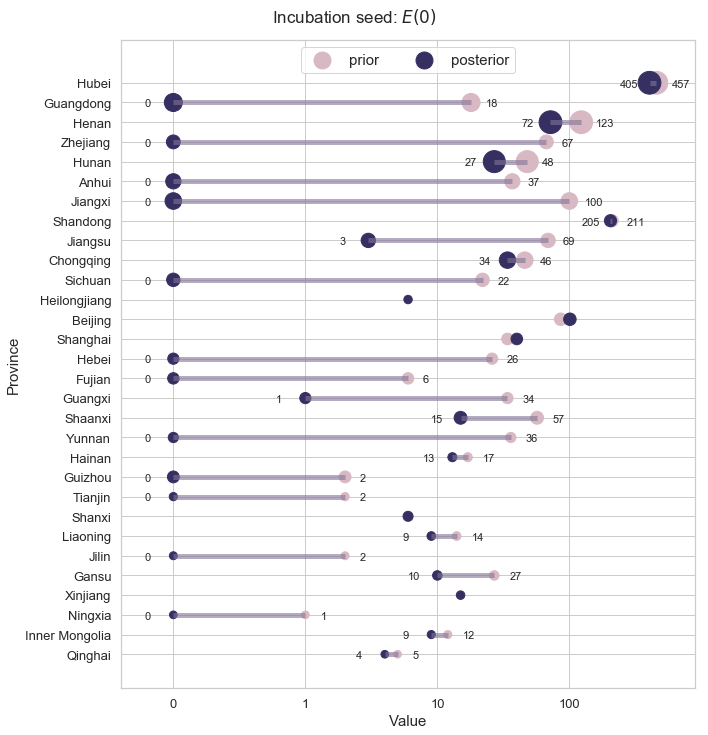

In [417]:
bars, mbars = figure_parameters_bar(df_parameters_list, df_mparameters_list,
                         fsize= (10, 10), fs = 15, title = 'Incubation seed: ' + r'$E(0)$', country = 'China', target = 'E_0')

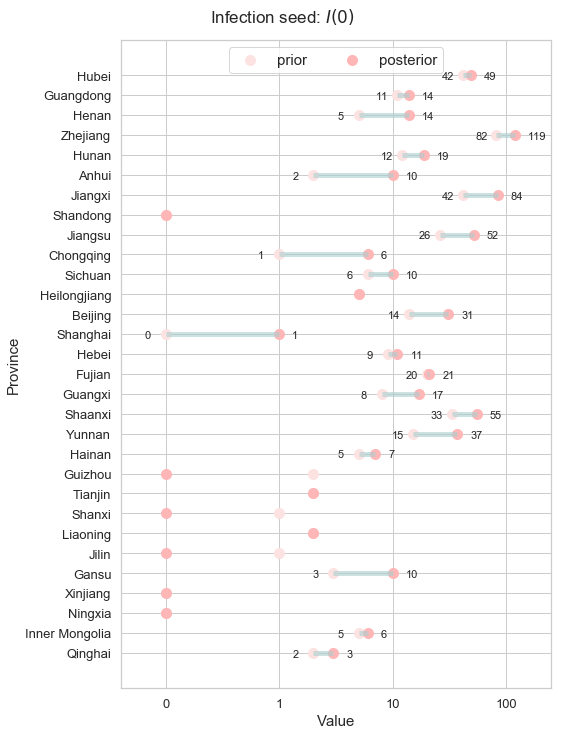

In [418]:
bars, mbars = figure_parameters_bar(df_parameters_list, df_mparameters_list,
                         fsize= (8, 10), fs = 15, title = 'Infection seed: ' + r'$I(0)$', country = 'China', target = 'I_0')

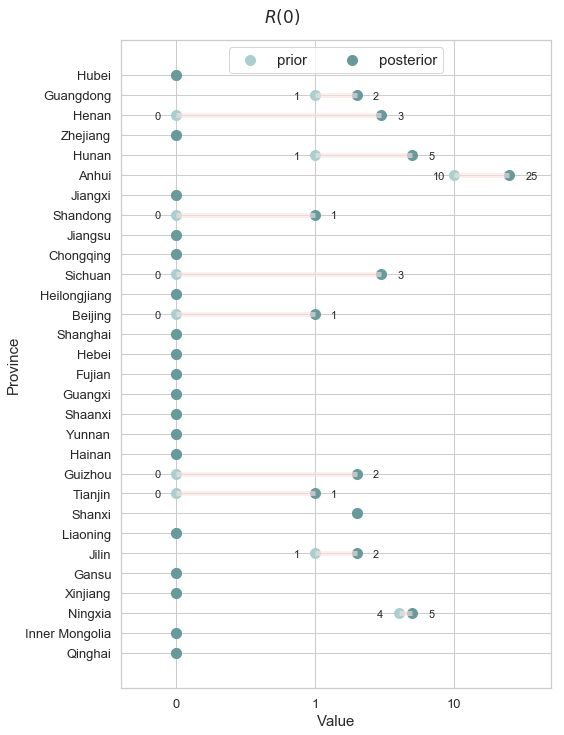

In [419]:
bars, mbars = figure_parameters_bar(df_parameters_list, df_mparameters_list,
                         fsize= (8, 10), fs = 15, title = r'$R(0)$', country = 'China', target = 'R_0')


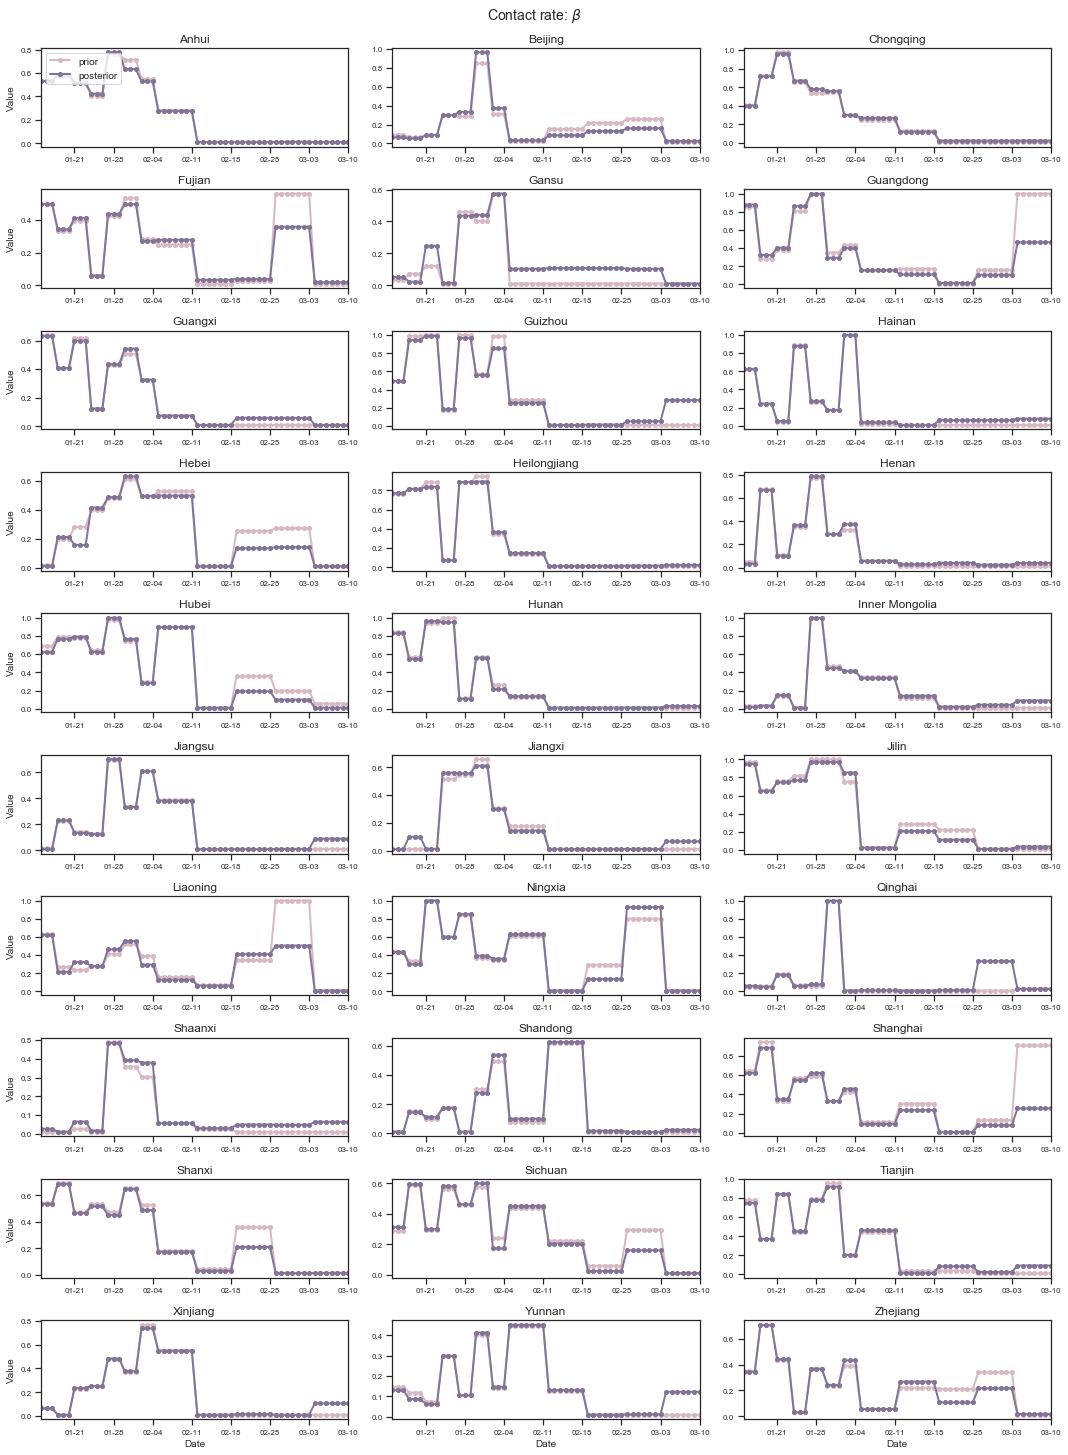

In [414]:
date_tr = datetime.date(int(2020),int(3),int(10))
figure_parameters(df_parameters_list, df_mparameters_list, df_estimation_list, 
                  names_province = names_province, update_date_tr = date_tr,
                  fsize = (5, 2), ncol = 3, ms = 4, fs = 12, 
                  title = r'Contact rate: $\beta$', country = 'China',
                  top = False, ndays = 56)

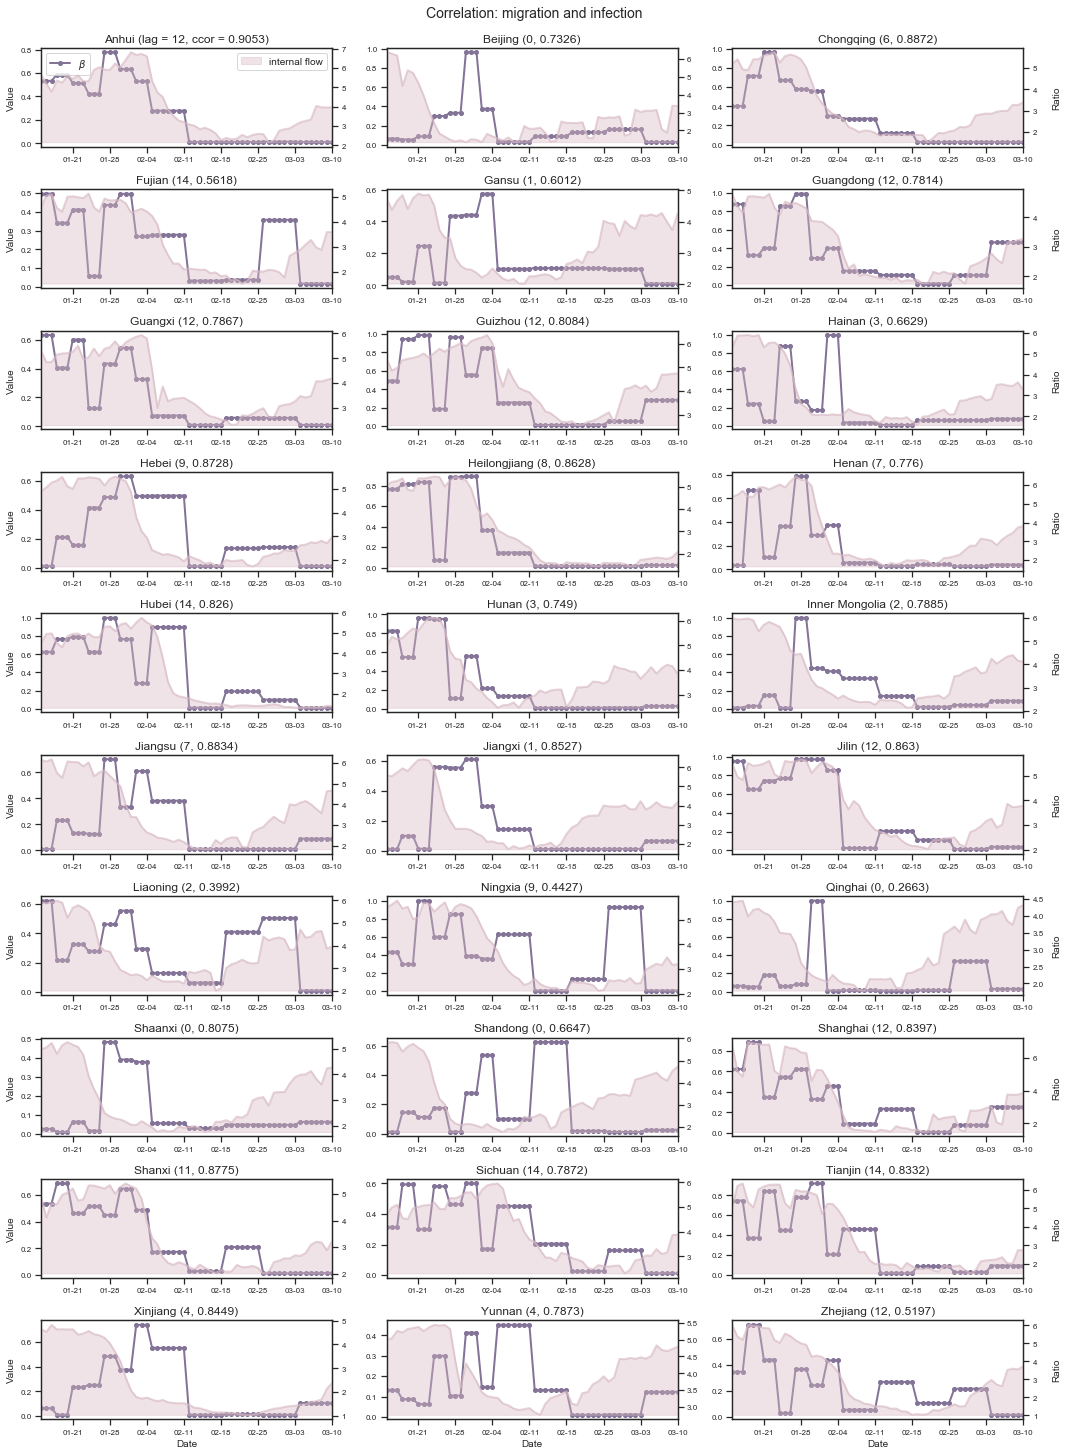

In [65]:
date_tr = datetime.date(int(2020),int(3),int(10))
# ndays: only keep the data of the first ndays
figure_parameters_if(df_mparameters_list, df_mestimation_list,
                     data_if_province, names_province, date_tr, ndays = 56, 
                     fsize = (5, 2), ncol = 3, ms = 4, fs = 12, 
                     title = 'Correlation: migration and infection', country = 'China', top = False)

In [420]:
ccor_list = []
for i, name in enumerate(names_province):
    ccor, lag = cross_correlation(df_mparameters_list, df_mestimation_list, data_if_province, date_tr, i, ndays = 56, printing = False)
    ccor_list.append(ccor)
    
    

In [427]:
np.sum([1 if item >= 0.7 else 0 for item in ccor_list])

22

In [425]:
min(ccor_list)

0.26630093801740445